In [1]:
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
# autoreload setup
%load_ext autoreload
%autoreload 1
%aimport physio_def_2, Automatic1, Regions1, numeric

import javabridge
from bioformats import JARS as bfJARS
javabridge.start_vm(class_path=bfJARS, max_heap_size="6G")

import numpy as np
from Regions1 import Regions
from caiman import movie as cmovie
# merge obvious ROIs
from Regions1 import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph
import matplotlib.pyplot as plt
import pickle
from Automatic1 import saveRois
from physio_def_2 import Recording

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.



In [2]:
from pandas import Timedelta

In [7]:
# folder = "local_data/prototype/"
folder = "local_data/Sandra/2020_06_18/"

In [8]:
def get_filterSizes(px):
    base = int(np.ceil(6/px))
    wider = int(np.ceil(base*1.1))
    if wider==base: wider += 1
    toComb = int(np.ceil(base*1.3))
    if toComb <= wider: toComb += 1
    return [(base,), (wider,), (base,wider), (base,toComb)]

### Process Lifs

In [10]:
lifs = [f for f in os.listdir(folder) if f.endswith("lif") and f[0]!="."]
lifs = sorted(lifs)
lifs

['Experiment54a.lif',
 'Experiment54b.lif',
 'Experiment54c.lif',
 'Experiment54d.lif',
 'Experiment54e.lif']

In [11]:
# for exp in lifs:
#     rec = Recording(os.path.join(folder,exp))
#     rec.parse_metadata()
#     rec.save_metadata()

In [12]:
for exp in lifs:
    print (exp)
    rec = Recording(os.path.join(folder,exp))
    toDrop = [i for i,row in rec.metadata.iterrows() if "Series" not in row["Name"]]
    rec.metadata.drop(index=toDrop, inplace=True)
    if len(rec.metadata)>1:
        rec.calc_gaps()
        ff = np.any(
                [rec.metadata["gap"]>Timedelta("5s")]+
                [rec.metadata[c].diff().abs()>0 for c in ["pxSize", "SizeX", "SizeY"]],
            axis=0)
        sers = np.split(rec.metadata.Name.values, np.where(ff)[0])
    else:
        sers = [rec.metadata.Name.values]
    for serlist in sers:
        if len(serlist)==len(rec.metadata):
            ser="all"
        else:
            serrange = [int(el.replace("Series","")) for el in serlist]
            if len(serrange)>1:
                ser = "Series%03i-%i"%(serrange[0],serrange[-1])
            else:
                ser = "Series%03i"%(serrange[0])
        print("\t", ser, end="\t")
        saveDir = os.path.join(rec.folder, rec.Experiment+"_analysis", ser)
#         if os.path.isdir(saveDir):
#             donePickles = [(p,"%.1f"%(os.path.getsize(os.path.join(saveDir,p))/1e6)) \
#                            for p in os.listdir(saveDir) \
#                            if p.endswith("pkl") \
#                            and os.path.getsize(os.path.join(saveDir,p))>20e6
#                           ]
# #             donePickles = []
#             if len(donePickles)>=4:
#                 print(donePickles, "....done")
#                 continue
        print ("Need to work on ", saveDir)
        
        
        try:
            rec.import_series(ser)
        except:
            print (f"could not import {ser}")
            continue
        metadata = rec.Series[ser]["metadata"]
        filtSizes = get_filterSizes(metadata.pxSize)
        movie = cmovie(rec.Series[ser]["data"],fr=metadata["Frequency"])
        # break
        regions = Regions(movie, full=False, diag=True, debleach=False)

        for spFilt in filtSizes:
            pickleFile = os.path.join(saveDir, ".".join(map(str,spFilt))+"_rois.pkl")
            if os.path.isfile(pickleFile) and os.path.getsize(pickleFile)>100:
                continue
            else:
                print ("processing with filter size of ", spFilt)
            regions.constructRois(gSig_filt=spFilt)
            regions.update()
            while True:
                peak2bnd = getPeak2BoundaryDF(regions.df)
                df = peak2bnd.query("dist<1.")[["i","j"]]
                if len(df)==0: break
                gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
                dropped = mergeBasedOnGraph(gRois,regions)
                if dropped == 0: break

            regions.purge_lones((min(spFilt)*.5)**2)
            regions.sortFromCenter()
            saveRois(regions, saveDir, filename= ".".join(map(str,spFilt)), add_date=False, formats=["vienna"])
            assert hasattr(regions, "movie")
        del rec.Series[ser], regions, movie
    print ("")

Experiment54a.lif
Recording not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... Finished.
	 Series003	Need to work on  local_data/Sandra/2020_06_18/Experiment54a.lif_analysis/Series003
processing with filter size of  (8,)
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
764 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
20 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
2 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
0 subsumed into existing ROIs.
deleted 60 rois. 237 remain.
vienna
processing with filter size of  (9,)
more than two attractors, not implemented yet, will skip
673 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
18 subsumed into existing ROIs.
more than two at

36 subsumed into existing ROIs.
1 subsumed into existing ROIs.
deleted 88 rois. 194 remain.
vienna
processing with filter size of  (5,)
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
446 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
more than two attractors, not implemented yet, will skip
24 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
16 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
1 subsumed into existing ROIs.
more than two attractors, not implemented yet, will skip
0 subsumed into existing ROIs.
deleted 91 rois. 151 remain.
vienna
processing with filter size of  (4, 5)
338

### Add images

In [13]:
toBreak = False
for cur,dirs,files in os.walk(folder):
    for file in files:
        if file.endswith('pkl') and "meta" not in file:
            path = os.path.join(cur,file)
            assert os.path.isfile(path)
            imageFile = os.path.join(cur, ".image_"+file.replace("_rois.pkl",".png"))
            if os.path.isfile(imageFile):
                continue
            print (path)
            with open(path,'rb') as f:
                regions = pickle.load(f)
            regions.update()
            im = regions.image
            figsize=np.array(im.shape)[::-1]/40
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            regions.plotEdges(ax=ax,color="red")
            fig.savefig(imageFile)
            plt.close(fig)
            toBreak = False
    if toBreak: break

local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series002/4.6_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series002/5_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series002/4_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series002/4.5_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series001/4.6_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series001/5_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series001/4_rois.pkl
local_data/Sandra/2020_06_18/Experiment54e.lif_analysis/Series001/4.5_rois.pkl
local_data/Sandra/2020_06_18/Experiment54d.lif_analysis/Series004/4.6_rois.pkl
local_data/Sandra/2020_06_18/Experiment54d.lif_analysis/Series004/5_rois.pkl
local_data/Sandra/2020_06_18/Experiment54d.lif_analysis/Series004/4_rois.pkl
local_data/Sandra/2020_06_18/Experiment54d.lif_analysis/Series004/4.5_rois.pkl
local_data/Sandra/2020_06_18/Experiment54d.lif_analysis/Series00

### Power spectra

In [16]:
from numeric import power_spectrum

In [15]:
folder = "local_data/prototype/"

In [17]:
pw = []
for cur,dirs,files in os.walk(folder):
    for file in files:
        if file.endswith('lif'):
            path = os.path.join(cur,file)
            rec = Recording(path)
            toDrop = [i for i,row in rec.metadata.iterrows() if "Series" not in row["Name"]]
            rec.metadata.drop(index=toDrop, inplace=True)
            ser = rec.metadata.Name.iloc[0]
            rec.import_series(ser)
            data = rec.Series[ser]["data"]
            meanImage = data.mean(0)
            metadata = rec.Series[ser]["metadata"]
            regions = Regions(meanImage, gSig_filt=(max(2,int(4/metadata.pxSize)),))
            freq = metadata["Frequency"]
            x = np.vstack([ data[:,p[0],p[1]] for p in regions.df.peak])
            f,p = power_spectrum(x, fr=freq)
            metadata["f"] = f
            metadata["p"] = p
            metadata["exp"] = file
            pw += [metadata]

ValueError: could not broadcast input array from shape (64,128) into shape (128,64)

In [19]:
import pandas as pd

In [20]:
pd.DataFrame(pw)

,Name,SizeT,SizeX,SizeY,pxSize,pxUnit,bit depth,Frequency,Start time,End time,Duration,individual Series,f,p,exp
0,Series009,128000,128,128,1.540,µm,uint8,84.20,2020-05-18 11:40:41,2020-05-18 12:06:01.802881639,00:25:20.802881,Name SizeT Start time ...,"[0.0, 0.0006578125, 0.001315625, 0.0019734375,...","[(415432.36842105264+0j), (24481.798210530415-...",Experiment49b.lif
1,Series009,128000,128,128,2.040,µm,uint8,84.20,2019-10-16 11:37:40,2019-10-16 12:03:00.128876586,00:25:20.128876,Name SizeT Start time ...,"[0.0, 0.0006578125, 0.001315625, 0.0019734375,...","[(903305.3872919818+0j), (76732.37896787236-19...",Experiment39c.lif
1,Series003,342,512,512,0.538,µm,uint8,0.47,2015-11-16 11:47:12,2015-11-16 11:59:19.192293240,00:12:07.192293,Name SizeT Start time ...,"[0.0, 0.0013742690058479532, 0.002748538011695...","[(31647.494371482175+0j), (-459.10252037366445...",ExperimentOGB.lif
0,Series002,11782,256,256,1.210,µm,uint8,9.89,2020-06-17 16:53:57,2020-06-17 17:13:48.404120199,00:19:51.404120,Name SizeT Start time ...,"[0.0, 0.0008394160583941605, 0.001678832116788...","[(42744.47772474145+0j), (79.28271477086312-11...",Experiment53b.lif
0,Series001,32000,256,256,1.220,µm,uint8,50.00,2020-05-27 13:18:51,2020-05-27 13:29:30.390981258,00:10:39.390981,Name SizeT Start time ...,"[0.0, 0.0015625, 0.003125, 0.00468750000000000...","[(81340.7780511811+0j), (178.27744743520933-37...",Experiment50b.lif
0,Series003,128000,128,128,1.530,µm,uint8,84.10,2020-05-27 10:50:04,2020-05-27 11:15:25.234884220,00:25:21.234884,Name SizeT Start time ...,"[0.0, 0.0006570312500000001, 0.001314062500000...","[(455515.3851851852+0j), (-9146.852927356314-4...",Experiment50a.lif
0,Series001,32000,256,256,1.210,µm,uint8,50.10,2020-05-18 17:25:06,2020-05-18 17:35:45.305979517,00:10:39.305979,Name SizeT Start time ...,"[0.0, 0.001565625, 0.00313125, 0.004696875, 0....","[(28150.35644637053+0j), (-280.4986583308203-1...",Experiment49f.lif
0,Series001,128000,128,128,2.020,µm,uint8,84.20,2019-10-16 15:08:24,2019-10-16 15:33:44.317877239,00:25:20.317877,Name SizeT Start time ...,"[0.0, 0.0006578125, 0.001315625, 0.0019734375,...","[(609804.5604249667+0j), (8887.489035253904-49...",Experiment39f.lif
0,Series010,128000,128,128,1.530,µm,uint8,84.20,2020-05-18 10:25:37,2020-05-18 10:50:57.194877087,00:25:20.194877,Name SizeT Start time ...,"[0.0, 0.0006578125, 0.001315625, 0.0019734375,...","[(483354.7082728592+0j), (46939.68056771977-10...",Experiment49a.lif
2,Series012,84156,128,128,2.020,µm,uint8,84.20,2019-10-16 14:47:59,2019-10-16 15:04:38.566877853,00:16:39.566877,Name SizeT Start time ...,"[0.0, 0.0010005228385379533, 0.002001045677075...","[(818632.8293706292+0j), (15181.93088547999-92...",Experiment39e.lif


(0, 1000)

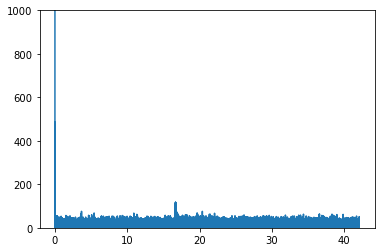

In [18]:
plt.plot(*power_spectrum(x, fr=freq))
plt.ylim(0,1000)

In [20]:
pw

[]

In [6]:
javabridge.kill_vm()

In [26]:
df = []
for cur,dirs,files in os.walk(folder):
    for file in files:
        if file.endswith('pkl'):
            path = os.path.join(cur,file)
            row = {"exp":path.split(".lif")[0].split("/")[-1],
                   "ser":os.path.split(cur)[-1],
                   "size":os.path.getsize(path)/1e6,
                   "path":path,
                  }
            imageFile = os.path.join(cur, ".image_"+file.replace("_rois.pkl",".png"))
            row["image"] = os.path.isfile(imageFile)
            df += [row]
#             print (path)
#             with open(path,'rb') as f:
#                 regions = pickle.load(f)
#             regions.update()
#             im = regions.image
#             figsize=np.array(im.shape)[::-1]/40
#             fig = plt.figure(figsize=figsize)
#             ax = fig.add_axes([0, 0, 1, 1])
#             regions.plotEdges(ax=ax,color="red")
#             fig.savefig(imageFile)
#             plt.close(fig)
#             toBreak = False
#     if toBreak: break

In [27]:
import pandas as pd

In [28]:
df = pd.DataFrame(df)

In [32]:
x = [ddf['size'].values for (exp,ser),ddf in df.groupby(["exp","ser"])]

In [35]:
from general_functions import tally

In [36]:
tally(map(len,x))

[(4, 87)]

In [37]:
x = np.array(x)

(array([14.,  2.,  2., 11., 26.,  9.,  6.,  7.,  6.,  4.]),
 array([0.00658561, 0.02932093, 0.05205624, 0.07479156, 0.09752687,
        0.12026218, 0.1429975 , 0.16573281, 0.18846813, 0.21120344,
        0.23393875]),
 <a list of 10 Patch objects>)

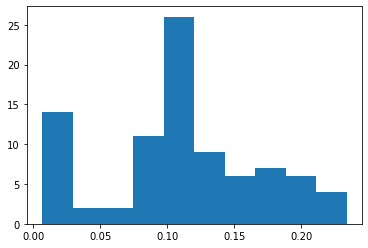

In [41]:
cv = x.std(1)/x.mean(1)
plt.hist(cv)

In [44]:
x[np.argmin(cv)]

array([11.850477, 11.858177, 11.667351, 11.760294])

In [48]:
(~df.image).any()

False